# Dataset rendering

## Creating the dataset

- Import useful libraries and constuct defaults

In [1]:
import matplotlib.colors
import numpy as np
from sklearn.decomposition import PCA

np.random.seed(42)

# Prevent warnings
%matplotlib inline
import matplotlib.pyplot as plt

import cv2      # for loading images

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit

import seaborn as sns
# Reset Matplotlib style to default
plt.rcdefaults()

Initialize constants and import the height field data:

The map seems to house some outliers: some hundreds of raster points have values that are kilometers greater than the maximum elevation of Olympus Mons, Mars' highest mountain. Highest values seem to stabilize around the 21km mark.

In [2]:
#Maximum latitude (N or S) in degrees we want to consider
maxLat = 45

#The resolution of the source image (px/m)
(dx, dy) = 463, 463

# The maximum step size we will allow for rays. This has to be specified
# for a reason relating to the homogeneity of the dataset.
MAX_RAY_STEP = 128

large_height_field_raw = cv2.imread('Mars_MGS_MOLA_DEM_mosaic_global_463m.tif', cv2.IMREAD_UNCHANGED)

#Observe the 1000 biggest values
#a = np.sort(large_height_field_raw.reshape(-1,))[::-1]
#print(a[:1000])

raw_height, raw_width = large_height_field_raw.shape

maxOffset = int(maxLat/(2 * 90.0) * raw_height)    # Maximum height offset from equator
maxH_Ind = int(raw_height/2 + maxOffset)
minH_Ind = int(raw_height/2 - maxOffset)

# Filter away high latitudes, where projection skews the map. Normalize the map.
large_height_field = large_height_field_raw[minH_Ind:maxH_Ind, :] / float(dx)

# Check the highest and lowest values. The hightes point on Mars is between 20 and 22km above the reference datum.
# The lowest point is between 8km and 9km below it. The values are stored in meters, so max should be about 21000 and
# min should be about -8000.
print("Minimum value in the height field (meters): ", large_height_field.max() * dx)
print("Maximum value in the height field (meters):", large_height_field.min() * dx)

#assert (large_height_field.max()/1000 == 21)
#assert (large_height_field.min()/1000 == -(8+1))    # Integer division truncates downward

height, width = large_height_field.shape

Minimum value in the height field (meters):  31060.0
Maximum value in the height field (meters): -8201.0


[14.63714903  6.78401728  2.46436285 -0.22678186  3.412527  ]


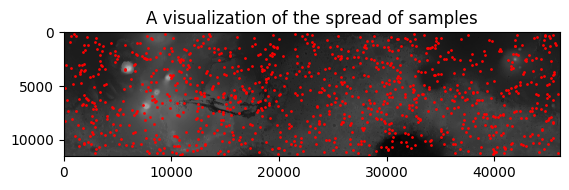

In [26]:
numPoints = 100000
xIndices = []   # Indices double as (x) positions
yIndices = []   # Indices double as (y) positions
zElevations = []    # z values (floats)

for _ in range(numPoints):
    # Generate (x,y) coordinates within the valid range. Restrict x axis slightly, so as
    # to allow for padding (we will get no issues with buffer under/overflow)
    x = np.random.randint(MAX_RAY_STEP, width - MAX_RAY_STEP)
    y = np.random.randint(MAX_RAY_STEP, height - MAX_RAY_STEP)
    # Get and normalize the corresponding z point.
    # Normalize the z value: make a unit height as equivalent (in real-world distance) to a pixel width
    # Indexing an image opened by cv2 is, against intuition, (y,x)
    z = large_height_field[y,x]

    xIndices.append(x)
    yIndices.append(y)
    zElevations.append(z)

xIndices = np.array(xIndices)
yIndices = np.array(yIndices)
zElevations = np.array(zElevations)
fig, ax1 = plt.subplots(1,1)
ax1.imshow(large_height_field, cmap='gray')
ax1.set_title("A visualization of the spread of samples")
# Visualize some of the points to check if they're distributed as we would want.
ax1.scatter(xIndices[:1000], yIndices[:1000], color = 'red', s=1)
# get an idea of height values
print(zElevations[:5])

### Generating gradients

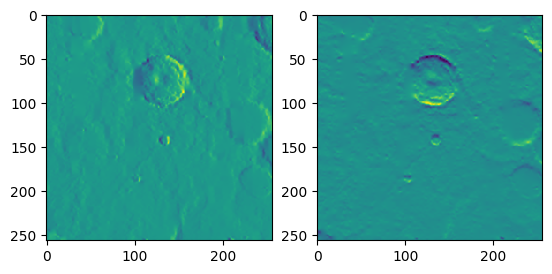

In [4]:
grad_img_x = (np.gradient(large_height_field, axis=1))
grad_img_y = (np.gradient(large_height_field, axis=0))

fig, (ax1,ax2) = plt.subplots(1,2)
# Have a look at some position, see if the gradients "look" sensible
ax1.imshow(grad_img_x[7000:7256,3000:3256], interpolation='none')
ax2.imshow(grad_img_y[7000:7256,3000:3256], interpolation='none')

# CV images are indexed y,c
gradients_x = grad_img_x[yIndices, xIndices]
gradients_y = grad_img_y[yIndices, xIndices]

### Generating height and direction features

(100000,)


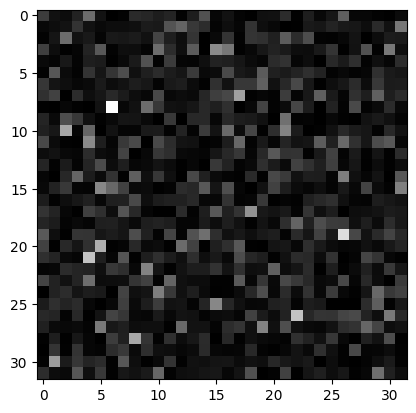

In [27]:
# Maximum relative height. 20000 meters in pixel units (463m/px)
max_rel_height = 20000/dx

# Generate random height values. Generate a random height offset, and add it to the ground height.
print(xIndices.shape)
# Exponential distribution: Take more samples closer to the ground
# (statistically, this will better reflect where the sample points will be.)
# lambda chosen so, that 0.1% of sample points will be over 20000m above ground:
# beta = 1/lambda = -x/ln(0.999), where x 20000m, or 20000m/(463m/px)≈43px
# beta = 6.25334
Beta = 6.25334
#rel_heights = np.random.uniform(low = 0, high = max_rel_height, size = xIndices.shape)
rel_heights = np.random.exponential(Beta, size = xIndices.shape)
#abs_heights = rel_heights + renders

# sanity check, display some of these height values. Should look like noise, with more dim values than bright.
fig, ax1 = plt.subplots(1,1)
ax1.imshow(rel_heights[:(32*32)].reshape(32,32), interpolation='none', cmap='gray')
#fig.suptitle("Randomized height offsets")

[100000, 3]
Min x:  0.9999968086772841
Max x:  -0.9999897370715172


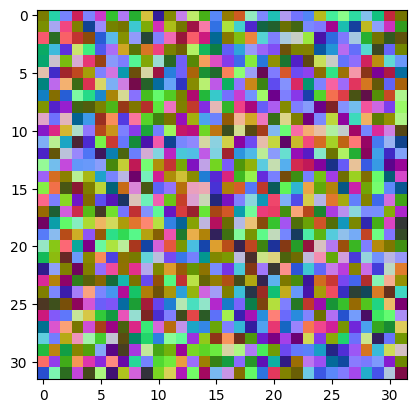

In [6]:
# Generating directions of ray casts
dir_shape = list(xIndices.shape) + [3]
print(dir_shape)
# Generate uniform random vectors on a sphere.
phi = np.random.rand(*xIndices.shape) * 2 * np.pi
theta = np.random.rand(*xIndices.shape) * 2 * np.pi
# rho = 1. We generate unit vectors, so this is not needed.
# Components can be stored in separate arrays.
dir_x = np.sin(phi) * np.cos(theta)
dir_y = np.sin(phi) * np.sin(theta)
dir_z = np.cos(phi)

# visualize it to see if it looks like vector noise.
dir_viz = ((np.stack((dir_x, dir_y, dir_z), axis=1) + 1)/2.0)[:32*32,:].reshape(32,32,3)
# check if value range is correct
print("Min x: ", np.max(dir_x))
print("Max x: ", np.min(dir_x))
fig, ax1 = plt.subplots(1,1)
ax1.imshow(dir_viz, interpolation='none')

### Finally, melt them all into a big feature vector

In [7]:
# Remember, renders holds the height of the terrain.
# Reshape the individual "images" into a continuous array
X = np.stack((zElevations, gradients_x, gradients_y, rel_heights, dir_x, dir_y, dir_z), axis = 1)
# Check if the shape is correct.
print(X.shape)
# Check some values
X[0:10, :]

(100000, 7)


array([[-5.20086393e+00, -9.71922246e-03, -2.15982721e-03,
         2.11948148e+01, -3.65557459e-02, -2.12088865e-02,
        -9.99106531e-01],
       [ 1.69330454e+00,  0.00000000e+00, -1.29589633e-02,
         3.58778512e+00, -6.95147778e-01,  6.48084269e-01,
         3.11056822e-01],
       [-6.44276458e+00, -2.26781857e-02,  4.42764579e-02,
         1.96559042e+00, -7.44235218e-02,  2.85967609e-02,
         9.96816615e-01],
       [-1.55723542e+00, -1.07991361e-03,  5.39956803e-03,
         6.89638977e-01,  6.08428462e-01, -7.34676989e-01,
        -3.00107528e-01],
       [ 1.79265659e-01,  5.83153348e-02,  1.72786177e-02,
         2.67810447e+00, -8.89934679e-03,  3.40277017e-02,
         9.99381267e-01],
       [ 4.18574514e+00, -3.23974082e-03,  5.39956803e-03,
         1.44692541e+01,  6.05030739e-01, -5.43259653e-01,
         5.82071091e-01],
       [ 2.71922246e+00,  1.40388769e-02, -4.85961123e-02,
         7.73774994e+00, -5.88824145e-01,  5.09045764e-01,
        -6.2782046

## Generating labels


0
5000.0
10000.0
15000.0
20000.0
25000.0
30000.0
35000.0
40000.0
45000.0
50000.0
55000.0
60000.0
65000.0
70000.0
75000.0
80000.0
85000.0
90000.0
95000.0
100000.0
CPU times: total: 58.5 s
Wall time: 58.6 s


array([ 38.45948  , 128.       , 128.       ,   2.9607592, 128.       ,
       128.       ,  14.930065 , 128.       ,   1.2277797,  12.892782 ],
      dtype=float32)

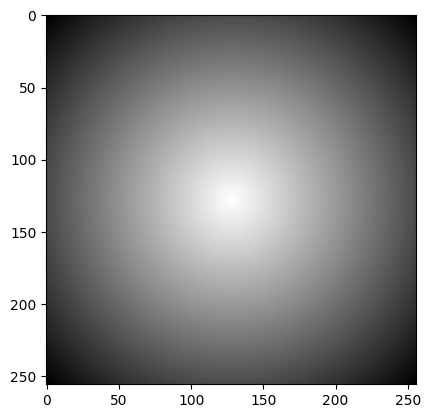

In [8]:
testPoints = zElevations + rel_heights      # Absolute height positions
# calculate minimum distances to geometry


# Calculate z cooridante of a cone (a ruled surface, here, the lines go along the negative z gradient of the dir vector).
# originating from the start_pos
# z = df/dz*norm([x-x0 y-y0])
def cone_dist(x,y):
    return np.sqrt(((x-MAX_RAY_STEP)*(x-MAX_RAY_STEP)+(y-MAX_RAY_STEP)*(y-MAX_RAY_STEP)))
# This "kernel" servse as a basis for the cone that is intersected with the terrain.
cone_kernel = np.fromfunction(np.vectorize(cone_dist), (MAX_RAY_STEP * 2, MAX_RAY_STEP * 2))
# visualize the kernel, see should be a radial gradient.
fig, ax1 = plt.subplots(1,1)
ax1.imshow(cone_kernel, cmap='gray_r', interpolation='none')

# x and y represent the indices of the pixel, img_index is the image on which to trace (from renders).
# Returns the minimum distance of intersection along a cone that is created by rotating the directional
# line along the y axis
# What I call this distance estimator. WARNING: Cone tracing has a different meaning in literature.
def cone_trace(x0, y0, z0, dirx, diry, dirz, count):

    # Fringe case, return distence to ground.
    if dirx == 0 and diry == 0: return z0 - large_height_field[y0, x0]

    # Get a square neighbourhood, into which the step definitely falls.
    # CV image, indexed in inverse
    neighbourhood = large_height_field[y0-MAX_RAY_STEP:y0+MAX_RAY_STEP, x0-MAX_RAY_STEP:x0+MAX_RAY_STEP]
    #print(neighbourhood.shape)
    # calculate the cone
    # Calculate z cooridante of a cone (a ruled surface, here, the lines go along the negative z gradient of the dir vector).
    # originating from the start_pos
    # z = df/dz*norm([x-x0 y-y0])
    cone = z0 + dirz*cone_kernel

    #fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    #ax1.imshow(neighbourhood, interpolation='none')
    #ax2.imshow(cone, interpolation='none')
    #ax3.imshow(neighbourhood >= cone, interpolation='none')
    # Indices where our plane intersects
    inter_xy = np.where(neighbourhood >= cone)

    # Calculate the
    dists = cone_kernel[inter_xy[0], inter_xy[1]]/np.cos(dirz)

    #progress counter
    if count%5000 == 0:
        print(count)

    if dists.size == 0: return MAX_RAY_STEP

    min_dist = np.min(dists)

    return min(min_dist, MAX_RAY_STEP)


a  = cone_trace(4000,8000,2, -1,0.2,0.05, 0)

vec_cone = np.vectorize(cone_trace, otypes=[np.float32])
# Generate the labels
absHeights = np.add(zElevations, rel_heights)
%time y = vec_cone(xIndices, yIndices, absHeights, dir_x, dir_y, dir_z, np.linspace(1, numPoints, numPoints))
# check some values
y[:10]

In [9]:
# Construct training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
# Split "test" into "test" and "validation"
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
# Create a cross-validator containing the information about our test and validation sets
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

# X_val in the "0th" validation set, exclude X_train from the validation set. For use in GridSearchCV
indices = [-1]*len(X_train) + [0] * len(X_val)
ps = PredefinedSplit(test_fold=indices)

## Visualiation
Finally, let's visualize the data to get some intuitive idea of its makeup.

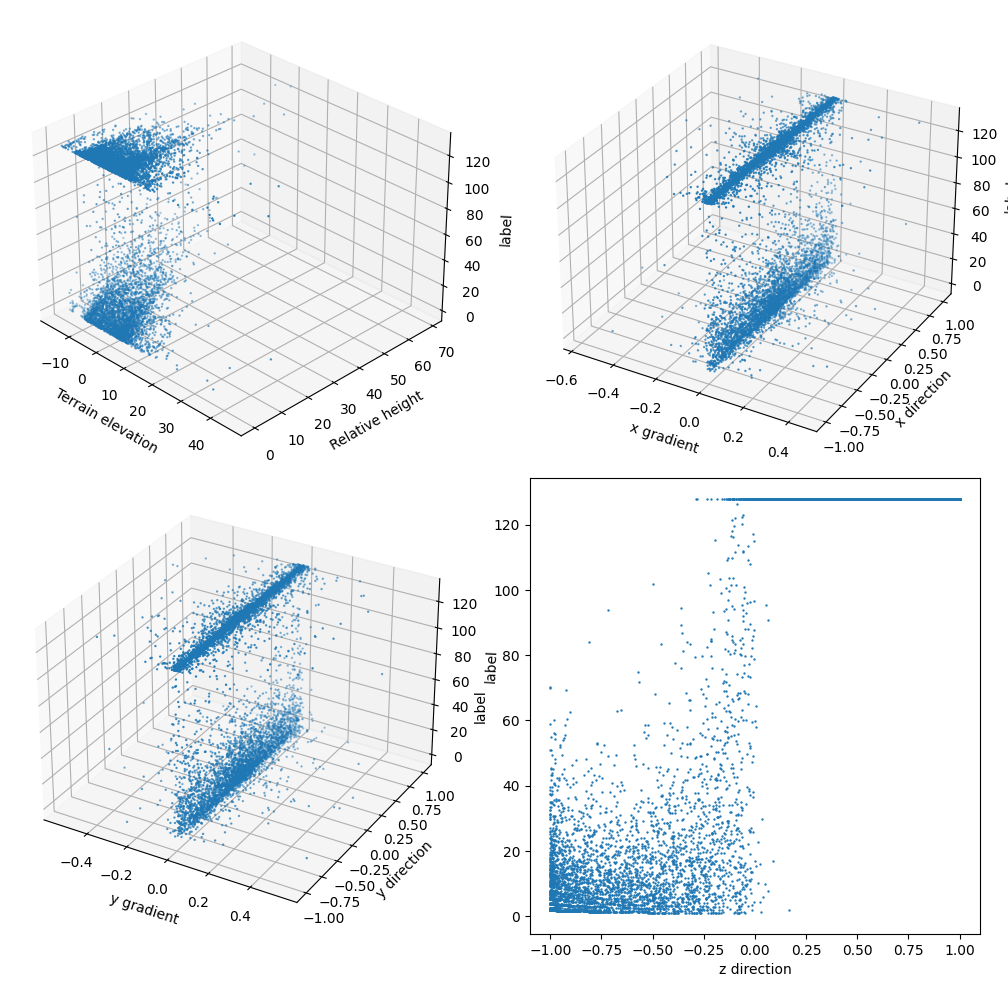

In [10]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,2,1, projection='3d')
ax.scatter(X_train[:8000,0], X_train[:8000,3], y_train[:8000], s = 0.5)
ax.set_xlabel("Terrain elevation")
ax.set_ylabel("Relative height")
ax.set_zlabel("label")
ax.view_init(elev = 30, azim = -45, roll = 0)

ax1 = fig.add_subplot(2,2,2, projection='3d')
ax1.scatter(X_train[:8000,1], X_train[:8000,4], y_train[:8000], s = 0.5)
ax1.set_xlabel("x gradient")
ax1.set_ylabel("x direction")
ax1.set_zlabel("label")
#ax3.view_init(elev = 30, azim = 45, roll = 0)

ax2 = fig.add_subplot(2,2,3, projection='3d')
ax2.scatter(X_train[:8000,2], X_train[:8000,5], y_train[:8000], s = 0.5)
ax2.set_xlabel("y gradient")
ax2.set_ylabel("y direction")
ax2.set_zlabel("label")
#ax2.view_init(elev = 0, azim = 90, roll = 0)

ax3 = fig.add_subplot(2,2,4)
ax3.scatter(X_train[:8000,6], y_train[:8000], s = 0.5)
ax3.set_xlabel("z direction")
ax3.set_ylabel("label")
#ax3.view_init(elev = 30, azim = 45, roll = 0)
fig.tight_layout()

plt.show()


Some distinguishable relations between features and labels can be seen.
The data seems to, as a whole, obey underlying distributions. What look like outliers appear sporadically, at best. Their presense also seems fairly symmetrically distributed as to the bulk of the data. Anywho, even if outliers are born out of the original height field, we can consider them genuine data points, as they are born out of some height-field image, albeit a slightly inaccurate one. We can then fairly confidently use mean squared loss.

The correlation of some of the features with the labels is a bit questionable. Since our feature count is quite large (7), the complexity of polynomial regression will quickly rise with degree. Given our performance goal, it would make sense to try and find a sparse solution. L1 regularization is then considered.

## Training the models

### Polynomial regressor
As our feature space is seven-dimensional, the amount of parameters needed to optimize are proportional to the seventh power of the degree.
This incurs very significant overhead for higher powers.
Before we start training, let's examine if we can reduce dimensionality, and thus gain performance via PCA:

Text(0, 0.5, 'Cumulative explained variance ratio')

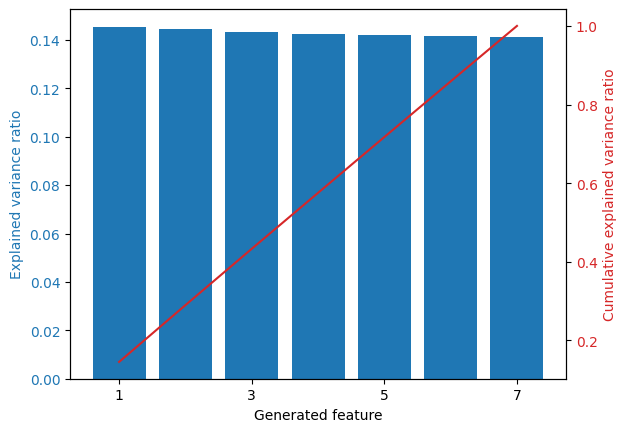

In [11]:
# NORMALIZE THE DATA BEFORE DOING PCA
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.fit_transform(X_val)
X_test_norm = scaler.fit_transform(X_test)

N = 7
pca = PCA(n_components=N)
X_train_reduced = pca.fit_transform(X_train_norm)
X_val_reduced = pca.transform(X_val_norm)
X_test_reduced = pca.transform(X_test_norm)


# plot the explained variances. Code taken from assignment 2.
fig = plt.figure()
ax1 = fig.add_subplot()
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=2))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)



It seems that all account for nearly the same amount of explained variance. We thus know that there are no redundant features. Unfortunately, this means that we cannot reduce the dimensionality of the model without losing relevant information.

In [12]:
%%time
degrees = range(1,7)

# Linear
train_errs = []
val_errs = []
params = []


for i in degrees:
    # Polynomial data prepping
    poly = PolynomialFeatures(i)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_val = poly.transform(X_val)

    # Fitting into a regression model
    ln = LinearRegression(fit_intercept=False)

    ln.fit(X_poly_train, y_train)
    y_pred_train = ln.predict(X_poly_train)
    y_pred_val = ln.predict(X_poly_val)

    train_errs.append(mean_squared_error(y_train, y_pred_train))
    val_errs.append(mean_squared_error(y_val, y_pred_val))
    print("DEGREE:\t", i , "\t PARAMETER COUNT:\t", len(ln.coef_))


DEGREE:	 1 	 PARAMETER COUNT:	 8
DEGREE:	 2 	 PARAMETER COUNT:	 36
DEGREE:	 3 	 PARAMETER COUNT:	 120
DEGREE:	 4 	 PARAMETER COUNT:	 330
DEGREE:	 5 	 PARAMETER COUNT:	 792
DEGREE:	 6 	 PARAMETER COUNT:	 1716
CPU times: total: 1min 20s
Wall time: 16.9 s


In [13]:
%%time
# Lasso
alphas = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

train_errs_L1 = []
val_errs_L1 = []
nonzero = []
search_metrics = []

for i in degrees:
    # Polynomial data prepping
    poly = PolynomialFeatures(i)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_val = poly.transform(X_val)
    X_poly_train_val = poly.transform(X_train_val)

    #%time alphas, coeffs, _ = lasso_path(X_poly_train, y_train, eps=0.2, n_alphas=5)
    #print(coeffs.shape)
    # Fitting into a regression model
    ln = Lasso(fit_intercept=False)

    # Since we have a constant split, we don't want to refit with the whole set.
    # TODO: Do we really need training scores?
    gSearch = GridSearchCV(ln, param_grid={'alpha' : alphas}, scoring="neg_mean_squared_error", cv = ps, n_jobs=-1, refit = False, return_train_score= True)
    %time gSearch.fit(X_poly_train_val, y_train_val)
    #print(gSearch.cv_results_)

    search_metrics.append(gSearch)
    #print("DEGREE:\t", i , "\tPARAMETER COUNT:\t", len(ln.coef_), "\tNONZERO:\t", len(ln.coef_[ln.coef_ != 0]))


CPU times: total: 46.9 ms
Wall time: 1.93 s
CPU times: total: 15.6 ms
Wall time: 3.94 s
CPU times: total: 78.1 ms
Wall time: 18.1 s
CPU times: total: 141 ms
Wall time: 1min 21s
CPU times: total: 562 ms
Wall time: 3min 21s
CPU times: total: 906 ms
Wall time: 6min 35s
CPU times: total: 4.86 s
Wall time: 11min 45s


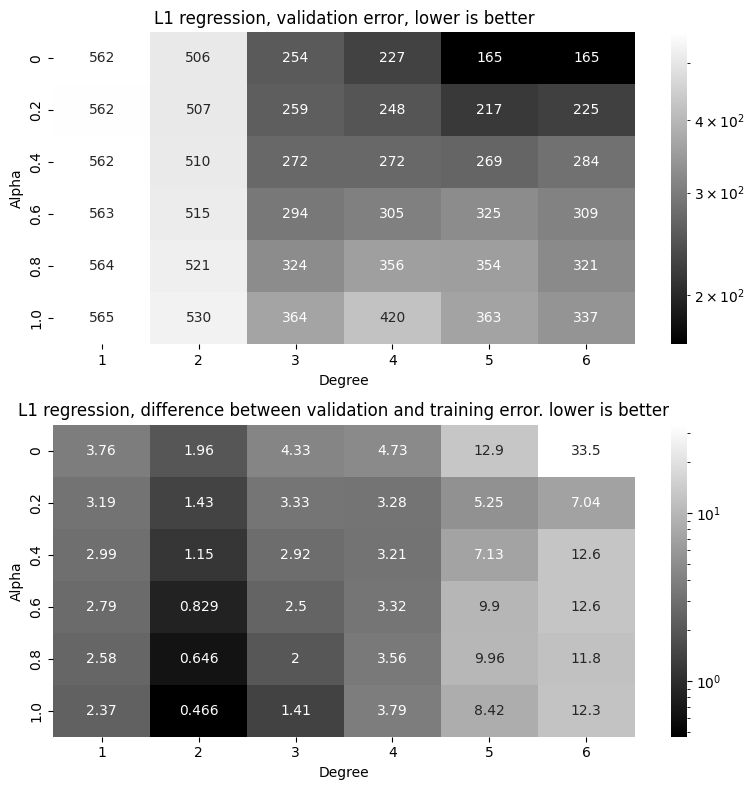

In [28]:
train_errs_L1 = np.array(list(map(lambda x : -x.cv_results_['mean_train_score'], search_metrics))).T
val_errs_L1 = np.array(list(map(lambda x : -x.cv_results_['mean_test_score'], search_metrics))).T
#print(search_metrics['mean_train_score'])

fig, ax = plt.subplots(2,1, figsize = (8,8))
# Plot a "Learning heatmap"
g = sns.heatmap(np.array(val_errs_L1).reshape(len(alphas),len(degrees)), annot=True,
            xticklabels=degrees, yticklabels=alphas, norm = matplotlib.colors.LogNorm(),
            ax=ax[0], vmin=0, cmap = "gray", annot_kws={"wrap":True}, fmt = '.3g')
g.set_title("L1 regression, validation error, lower is better")
g.set_xlabel("Degree")
g.set_ylabel("Alpha")

errorDiffs = np.array(val_errs_L1) - np.array(train_errs_L1)

g = sns.heatmap(np.array(errorDiffs).reshape(len(alphas),len(degrees)), annot=True,
                xticklabels=degrees, yticklabels=alphas, norm = matplotlib.colors.LogNorm(),
                ax=ax[1], vmin=0, cmap = "gray", annot_kws={"wrap":True}, fmt = '.3g')
g.set_title("L1 regression, difference between validation and training error. lower is better")
g.set_xlabel("Degree")
g.set_ylabel("Alpha")

plt.tight_layout()

It seems that the model doesn't improve much with degrees over 5. Since complexity is exponential, it makes sense to choose the smallest possible degree. Higher values of alpha should also be favoured.

We see that validation error reaches a minimum at alpha = 0, degree = 5. The difference between validation and training error is higher than most others, though it is still forgivable.

In the lasso model, on the other hand, degrees 3 and 5 are quite similar in performance. Based on the chosen design principles, a degree of 3 will thus be chosen.

### Multi-layer preceptron (artificial neural network)

Here, I first try different configurations: I vary the number of layers, as well as the number of nodes in a layer.

In [15]:
%%time
train_errs = []
val_errs = []

layers = range(1,6)
num_neurons = range(6,15)
layer_sizes = []
for i in layers:
    for j in num_neurons:
        layer_sizes.append([j]*i)

#print(layer_sizes)

# Keep the relu activation
mlp_regr = MLPRegressor(random_state=42, max_iter = 1000)

gSearch = GridSearchCV(mlp_regr, param_grid={'hidden_layer_sizes' : layer_sizes}, scoring="neg_mean_squared_error", cv = ps, n_jobs=-1, refit = False, return_train_score= True)
%time gSearch.fit(X_train_val, y_train_val)

CPU times: total: 156 ms
Wall time: 3min 51s
CPU times: total: 156 ms
Wall time: 3min 51s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MLPRegressor(max_iter=1000, random_state=42), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [[6], [7], [8], [9], [10], [11],
                                                [12], [13], [14], [6, 6],
                                                [7, 7], [8, 8], [9, 9],
                                                [10, 10], [11, 11], [12, 12],
                                                [13, 13], [14, 14], [6, 6, 6],
                                                [7, 7, 7], [8, 8, 8], [9, 9, 9],
                                                [10, 10, 10], [11, 11, 11],
                                                [12, 12, 12], [13, 13, 13],
                                                [14, 14, 14], [6, 6, 6, 6],
                                                [7, 7, 7, 7], [8, 8, 8, 8], ...]},
             refit=False, return_train_score=True,
             scoring='neg_mean_squared_error')

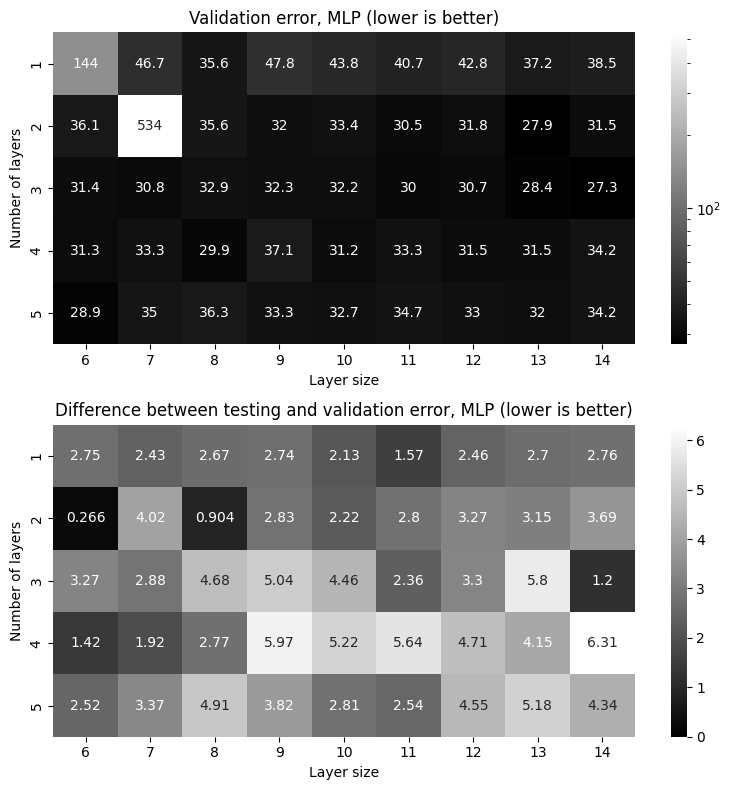

In [30]:
train_errs_MLP = -gSearch.cv_results_['mean_train_score']
val_errs_MLP = -gSearch.cv_results_['mean_test_score']

fig, ax = plt.subplots(2,1, figsize = (8,8))

# Plot a heatmap of the validation errors
g = sns.heatmap(np.array(val_errs_MLP).reshape(len(layers),len(num_neurons)), annot=True,
            yticklabels=layers, xticklabels=num_neurons, norm = matplotlib.colors.LogNorm(),
            ax=ax[0], vmin=0, cmap = "gray", annot_kws={"wrap":True}, fmt='.3g')

errorDiffs = np.array(val_errs_MLP) - np.array(train_errs_MLP)

g.set_title("Validation error, MLP (lower is better)")
g.set_xlabel("Layer size")
g.set_ylabel("Number of layers")


# Plot a heatmap of differences between valiation and training errors
g = sns.heatmap(errorDiffs.reshape(len(layers),len(num_neurons)), annot=True,
                yticklabels=layers, xticklabels=num_neurons,
                ax=ax[1], vmin=0, cmap = "gray", annot_kws={"wrap":True}, fmt='.3g')

errorDiffs = (np.array(val_errs) - np.array(train_errs))

g.set_title("Difference between testing and validation error, MLP (lower is better)")
g.set_xlabel("Layer size")
g.set_ylabel("Number of layers")
#fig, ax1 = plt.subplots(1,1)
#ax1.plot(layers, train_errs, label = 'Training error')
#ax1.plot(layers, val_errs, label = 'Validation error')
plt.tight_layout()

It looks like 3 layers and 7 nodes in a layer yields very good results, both in terms of validation error and difference to training error. The complexity yielded by these parameters is also on the lower end of the models considered (21 hidden nodes, altogether). These are thus chosen as the hyperparameters.

# Training and testing the final, chosen models

In [36]:
# Here, we fit the combined training and validation sets.
# Lasso regressor, first choice: Alpha = 0, degree = 5. This is just a polynomial regressor of degree 5.

# Polynomial data prepping
poly_ln = PolynomialFeatures(5)
X_poly_train_val = poly_ln.fit_transform(X_train_val)

#%time alphas, coeffs, _ = lasso_path(X_poly_train, y_train, eps=0.2, n_alphas=5)
#print(coeffs.shape)
# Fitting into a regression model
final_ln = LinearRegression(fit_intercept=False)
final_ln.fit(X_poly_train_val, y_train_val)
y_train_pred = final_ln.predict(poly_ln.transform(X_train_val))
y_test_pred = final_ln.predict(poly_ln.transform(X_test))
ln_train_err = mean_squared_error(y_train_val, y_train_pred)
ln_test_err = mean_squared_error(y_test, y_test_pred)
print("Model 1 train error: ", ln_train_err)
print("Model 1 test error: ", ln_test_err)

# Lasso regressor, second choice: Alpha = 0.6, degree = 3.

# Polynomial data prepping
poly_o = PolynomialFeatures(3)
X_poly_train_val = poly_o.fit_transform(X_train_val)

#%time alphas, coeffs, _ = lasso_path(X_poly_train, y_train, eps=0.2, n_alphas=5)
#print(coeffs.shape)
# Fitting into a regression model
final_lasso = Lasso(fit_intercept=False, alpha=0.6)
final_lasso.fit(X_poly_train_val, y_train_val)
y_train_pred = final_lasso.predict(poly_o.transform(X_train_val))
y_test_pred = final_lasso.predict(poly_o.transform(X_test))
lasso_train_err = mean_squared_error(y_train_val, y_train_pred)
lasso_test_err = mean_squared_error(y_test, y_test_pred)
print("Model 2 train error: ", lasso_train_err)
print("Model 2 test error: ", lasso_test_err)

# Final MLP: layers = 3, nodes = 7
final_mlp_regr = MLPRegressor(random_state=42, max_iter = 1000, hidden_layer_sizes=(7,7,7))
final_mlp_regr.fit(X_train_val, y_train_val)

# The final test
y_train_pred = final_mlp_regr.predict(X_train_val)
y_test_pred = final_mlp_regr.predict(X_test)
MLP_train_err = mean_squared_error(y_train_val, y_train_pred)
MLP_test_err = mean_squared_error(y_test, y_test_pred)
print("Model 3 train error: ", MLP_train_err)
print("Model 3 test error: ", MLP_test_err)

Model 3 train error:  32.68834137175584
Model 3 test error:  32.68834137175584
Model 1 train error:  152.54604831993805
Model 1 test error:  156.74328884668347
Model 2 train error:  292.5389236662301
Model 2 test error:  291.2230184202757
Model 3 train error:  28.77856749833474
Model 3 test error:  32.68834137175584


# The ray casting algorithm: real-world performance

Here, the trained model is assessed on a pseudo-application of ray casting: We line-of-sight images.

Here, I define a construct central to the project: the actual ray casting algorithm. The function's parameter "step_size_function" is a function that determines the step size on each iteration.

In [18]:
plt.rcdefaults()
renderSize = (256,256)

# Let the observer stand in the middle of the image
standing_x = int(renderSize[0]/2)
standing_y = int(renderSize[1]/2)
#standing_height = 10    # Assume our observer stands 10m above the local surface

#The ray casting algorithm. calculates the attenuation of signal advancing from start point to current point.
def raycast(x, y, standing_height_meters, step_size_function, height_map, gradient_x, gradinet_y):
    energy = 1.0
    # Convert to "pixel units"
    standing_height = standing_height_meters/dx
    # Start point of the trace
    pos = np.array([x, y, height_map[x, y]])
    # Vector position of observer
    standing_vec = np.array((standing_x, standing_y, standing_height + height_map[standing_x, standing_y]))
    # Vector from point to observer
    dirvec = standing_vec - pos
    #dirvec = np.array([standing_x-x, standing_y-y, standing_height - height_map[x,y]])

    length = np.linalg.norm(dirvec)
    remain = length
    #stepvec = (dirvec/length)*step_size_function(x)

    total_steps = 0

    while(remain > 0):
        intpos = pos.round().astype(int)
        #Get the wanted features
        grad_x = gradients_x[intpos[0]]
        grad_y = gradients_y[intpos[1]]
        terrain_elev = height_map[intpos[0], intpos[1]]
        rel_height = terrain_elev - pos[2]
        dir_x = (dirvec/length)[0]
        dir_y = (dirvec/length)[1]
        dir_z = (dirvec/length)[2]
        feature_vec = np.array((terrain_elev, grad_x, grad_y, rel_height, dir_x, dir_y, dir_z)).reshape(1,-1)

        step_size = max(1,step_size_function(feature_vec))
        step_size = min(step_size, MAX_RAY_STEP-1)
        stepvec = (dirvec/length)*step_size
        pos = pos + stepvec
        total_steps += 1
        remain -= step_size

        intpos = pos.round().astype(int)
        heightDelta = height_map[intpos[0], intpos[1]] - pos[2]
        if heightDelta > 0:
            energy = 0
        if energy == 0:
            break

    #print(x , " ", y)

    #total_steps to measure iteration count
    return np.clip(energy, 0, 1), total_steps

# Step function: First parameter gives the feature vector, second is a scalar to multiply the end result by.
# Constant step sizec
def constStep(stepSize, ratio):
    def inner(featurevec):
        return stepSize * ratio
    return inner

# Use our
def polyStep(ratio):
    def inner(featurevec):
        return final_ln.predict(poly_ln.transform(featurevec)) * ratio
    return inner

def lassoStep(ratio):
    def inner(featurevec):
        return final_lasso.predict(poly_o.transform(featurevec)) * ratio
    return inner

def MLPStep(ratio):
    def inner(featurevec):
        return final_mlp_regr.predict(featurevec) * ratio
    return inner
# The chosen, respective models for linear regression and MLP.


#def MLPStep:

#def PolyRegrStep:

[[ 0.34341253  0.36717063  0.36933045 ... -1.16846652 -1.18358531
  -1.1987041 ]
 [ 0.3412527   0.36717063  0.38012959 ... -1.174946   -1.19222462
  -1.20518359]
 [ 0.34773218  0.37365011  0.39092873 ... -1.18142549 -1.20302376
  -1.2224622 ]
 ...
 [ 0.89200864  0.88984881  0.88768898 ...  0.19006479  0.1987041
   0.20302376]
 [ 0.86609071  0.85961123  0.86609071 ...  0.1987041   0.20734341
   0.21166307]
 [ 0.85529158  0.85313175  0.86393089 ...  0.20734341  0.21166307
   0.21166307]]


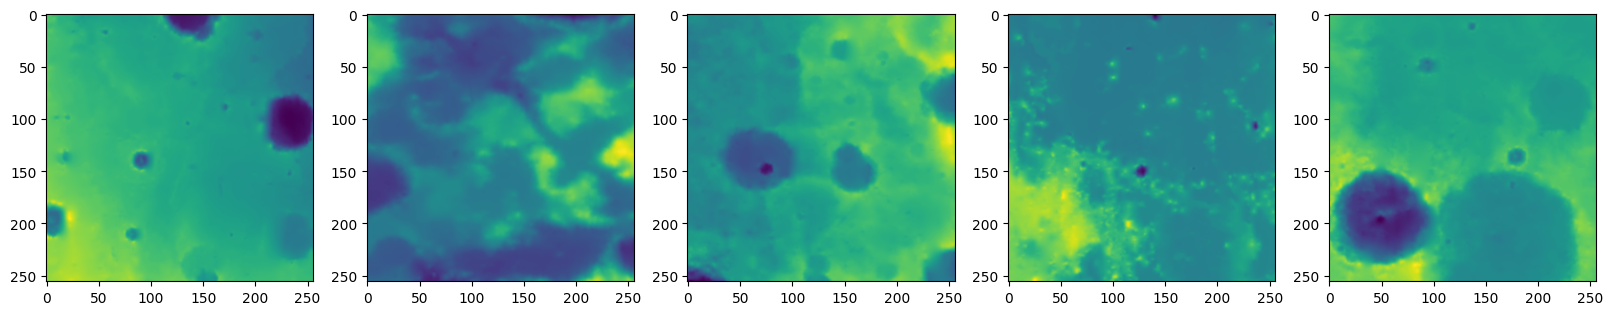

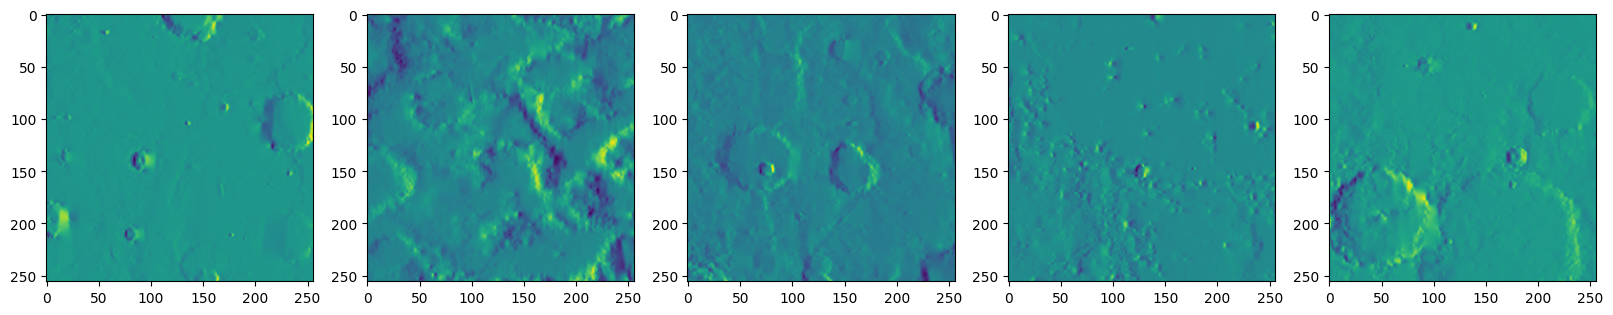

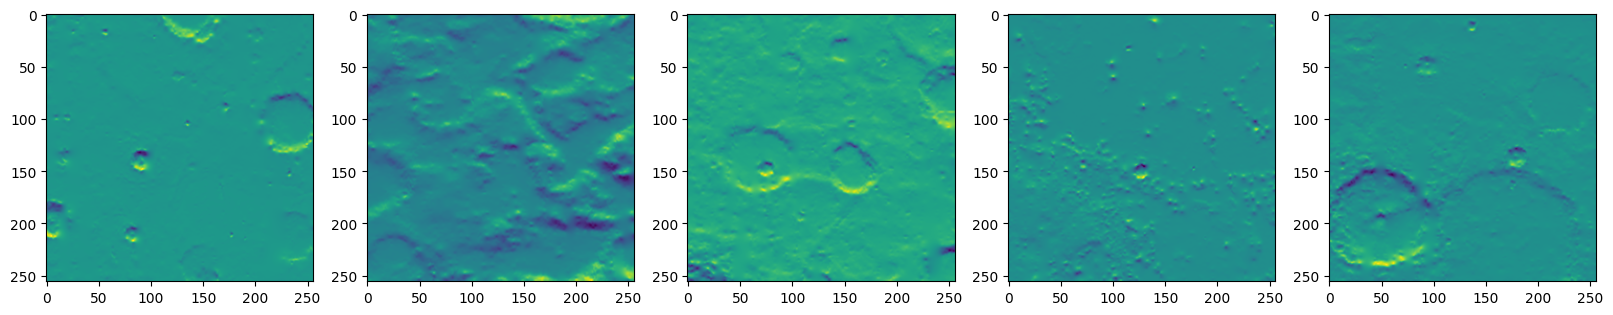

In [19]:
renders = []
grads_x = []
grads_y = []
num_renders = 5
for i in range(num_renders):
    x = np.random.randint(large_height_field.shape[1]-renderSize[1])
    y = np.random.randint(large_height_field.shape[0]-renderSize[0])
    r = large_height_field[y:y+renderSize[0], x:x+renderSize[1]]
    gx = (np.gradient(r, axis=1))
    gy = (np.gradient(r, axis=0))
    renders.append(r)
    grads_x.append(gx)
    grads_y.append(gy)
print(renders[0])

# Show the renders
fig, ax = plt.subplots(1, num_renders, figsize = (20, 4))
for i in range(num_renders):
    ax[i].imshow(renders[i])

# Show the gradients
fig, ax = plt.subplots(1, num_renders, figsize = (20, 4))
for i in range(num_renders):
    ax[i].imshow(grads_x[i])
fig, ax = plt.subplots(1, num_renders, figsize = (20, 4))
for i in range(num_renders):
    ax[i].imshow(grads_y[i])

In [20]:
%%time
radar_imgs_constFive = []
steps_constFive = 0
rows, cols = renderSize
# Generate "pseudeo-radar-images" using ray casting
for k in range(num_renders):
    radarimg = np.ones(renderSize)
    for i in range(rows):
        for j in range(cols):
            energy = 1
            e, steps = raycast(j,i, 100, constStep(5, 1), renders[k], gradients_x[k], gradients_y[k])
            energy *= e
            steps_constFive += steps
            radarimg[j,i] = energy

    radar_imgs_constFive.append(radarimg)

CPU times: total: 40.8 s
Wall time: 42 s


In [21]:
%%time
radar_imgs_poly = []
steps_poly = 0
rows, cols = renderSize
# Generate "pseudeo-radar-images" using ray casting
for k in range(num_renders):
    radarimg = np.ones(renderSize)
    for i in range(rows):
        for j in range(cols):
            energy = 1
            e, steps = raycast(j,i, 100, polyStep(1), renders[k], gradients_x[k], gradients_y[k])
            energy *= e
            steps_poly += steps
            radarimg[j,i] = energy

    radar_imgs_poly.append(radarimg)

CPU times: total: 2min 15s
Wall time: 2min 17s


In [22]:
%%time
radar_imgs_lasso = []
steps_lasso = 0
rows, cols = renderSize
# Generate "pseudeo-radar-images" using ray casting
for k in range(num_renders):
    radarimg = np.ones(renderSize)
    for i in range(rows):
        for j in range(cols):
            energy = 1
            e, steps = raycast(j,i, 100, lassoStep(1), renders[k], gradients_x[k], gradients_y[k])
            energy *= e
            steps_lasso += steps
            radarimg[j,i] = energy

    radar_imgs_lasso.append(radarimg)


CPU times: total: 1min 58s
Wall time: 1min 57s


In [23]:
%%time
radar_imgs_MLP = []
steps_MLP = 0
rows, cols = renderSize
# Generate "pseudeo-radar-images" using ray casting
for k in range(num_renders):
    radarimg = np.ones(renderSize)
    for i in range(rows):
        for j in range(cols):
            energy = 1
            e, steps = raycast(j,i, 100, MLPStep(1), renders[k], gradients_x[k], gradients_y[k])
            energy *= e
            steps_MLP += steps
            radarimg[j,i] = energy

    radar_imgs_MLP.append(radarimg)


CPU times: total: 1min 46s
Wall time: 1min 46s


Total steps with constant step of size 5:  2659633
Total steps with polynomial regression:  574670
Total steps with lasso:  588716
Total steps with MLP:  919438


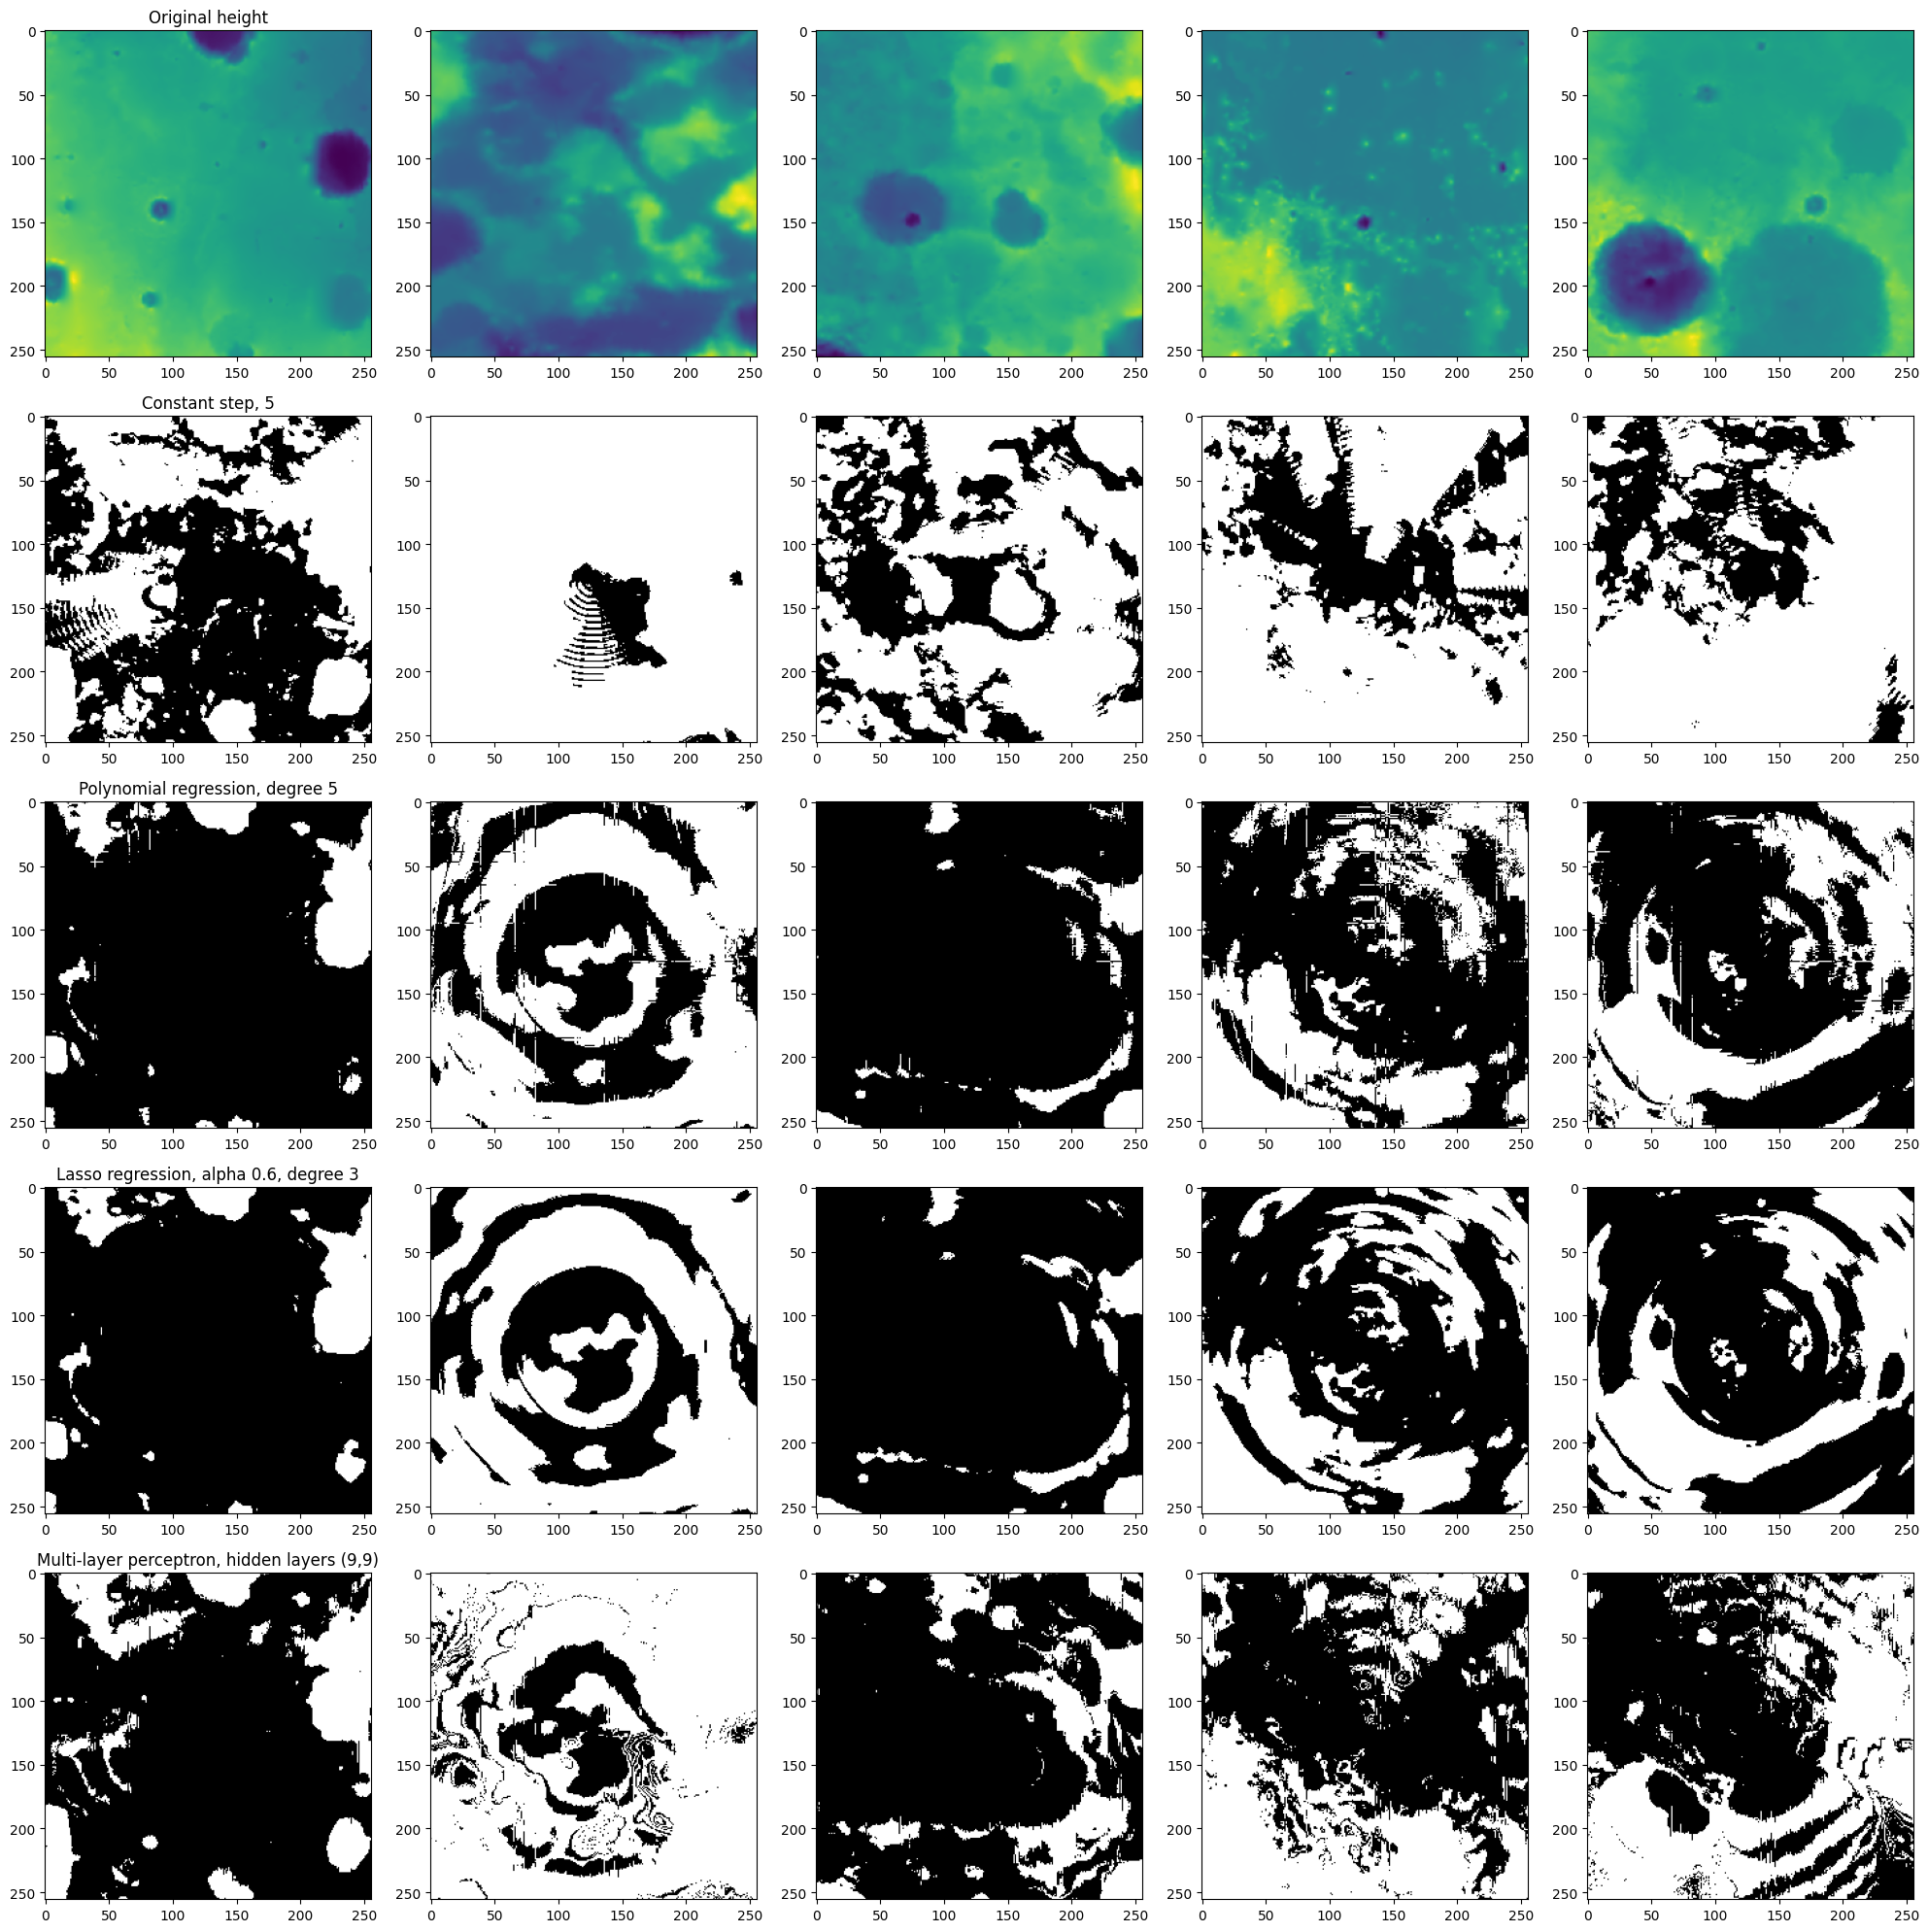

In [25]:

# Show the generated "radar images"
fig, ax = plt.subplots(5, num_renders, figsize = (20, 20))
print("Total steps with constant step of size 5: ", steps_constFive)
print("Total steps with polynomial regression: ", steps_poly)
print("Total steps with lasso: ", steps_lasso)
print("Total steps with MLP: ", steps_MLP)

ax[0,0].set_title("Original height")
for i in range(num_renders):
    ax[0][i].imshow(renders[i], cmap = 'viridis')

ax[1,0].set_title("Constant step, 5")
for i in range(num_renders):
    ax[1][i].imshow(radar_imgs_constFive[i], cmap = 'gray_r')

ax[2,0].set_title("Polynomial regression, degree 5")
for i in range(num_renders):
    ax[2][i].imshow(radar_imgs_poly[i], cmap = 'gray_r')

ax[3,0].set_title("Lasso regression, alpha 0.6, degree 3")
for i in range(num_renders):
    ax[3][i].imshow(radar_imgs_lasso[i], cmap = 'gray_r')

ax[4,0].set_title("Multi-layer perceptron, hidden layers (9,9)")
for i in range(num_renders):
    ax[4][i].imshow(radar_imgs_MLP[i], cmap = 'gray_r')



# Evaluate performance of the three chosen models
plt.tight_layout()
